In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install wurlitzer

In [2]:
!pip uninstall keras -y  # Force uninstall Keras
!pip install tensorflow==2.15.0  # Reinstall TensorFlow to ensure consistency

Found existing installation: keras 3.0.5
Uninstalling keras-3.0.5:
  Successfully uninstalled keras-3.0.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

2024-03-12 09:15:16.397637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 09:15:16.397822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 09:15:16.570414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
device_name = tf.test.gpu_device_name()
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    gpu_info = tf.config.list_physical_devices('GPU')[0]
    print(f"GPU Name: {gpu_info.name}")

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Data Generator

In [1]:
# reg_dataloader.py
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

class FunctionRegressionDataGenerator:
    def __init__(self, batch_size=64, max_num_context=10, testing=False):
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.testing = testing

    def generate_curves(self):
        # Define the kernel
        kernel = psd_kernels.ExponentiatedQuadratic(amplitude=1.0, length_scale=0.4)
        num_context = tf.random.uniform(shape=[], minval=50, maxval=self.max_num_context, dtype=tf.int32)
        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self.testing is True:
            num_target = 400
            num_total_points = num_target
            x_values = tf.expand_dims(
                tf.range(-2., 2., 1./100., dtype=tf.float32),
                axis=0)  # (1, 400)
            x_values = tf.tile(x_values, [self.batch_size, 1])  # (batch_size, 400)
            x_values = tf.expand_dims(x_values, axis=-1)  # (batch_size, 400, 1)
        else:
            num_target = tf.random.uniform(
                shape=[], minval=2, maxval=self.max_num_context, dtype=tf.int32)
            num_total_points = num_context + num_target
            x_values = tf.random.uniform(
                (self.batch_size, num_total_points, 1), minval=-2., maxval=2.)

        gp = tfd.GaussianProcess(
            kernel, index_points=x_values, jitter=1.0e-4)
        y_values = tf.expand_dims(gp.sample(), axis=-1)

        if self.testing is True:
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = tf.random.shuffle(tf.range(num_target))
            context_x = tf.gather(x_values, idx[:num_context], axis=1)
            context_y = tf.gather(y_values, idx[:num_context], axis=1)
        else:
            # Select the targets which will consist of the context points
            # as well as some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        yield (context_x, context_y, target_x), target_y


NameError: name 'tfp' is not defined

Encoder

In [5]:
# encoder.py
class Encoder(layers.Layer):
    def __init__(self, output_sizes):
        super(Encoder, self).__init__()
        self.output_sizes = output_sizes
        self.dense_layers = [layers.Dense(size, activation='relu') for size in output_sizes[:-1]]
        self.dense_layers.append(layers.Dense(output_sizes[-1]))

    def call(self, context_x, context_y):
        # `context_x` shape (batch_size, observation_points, x_dim)
        # `context_y` shape (batch_size, observation_points, y_dim)
        encoder_input = tf.concat([context_x, context_y], axis=-1)
        batch_size, num_context_points, filter_size = tf.shape(encoder_input)[0], tf.shape(encoder_input)[1], tf.shape(encoder_input)[2]

        hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))

        for layer in self.dense_layers:
            hidden = layer(hidden)

        hidden = tf.reshape(hidden, (batch_size, num_context_points, -1))
        representation = tf.reduce_mean(hidden, axis=1)

        return representation

Decoder

In [6]:
# decoder.py
class Decoder(layers.Layer):
    def __init__(self, output_sizes):
        super(Decoder, self).__init__()
        self.output_sizes = output_sizes
        # Initialize dense layers for MLP, using ReLU for all but last layer
        self.dense_layers = [layers.Dense(size, activation='relu') for size in output_sizes[:-1]]
        # Last layer without activation function
        self.dense_layers.append(layers.Dense(output_sizes[-1]))

    def call(self, representation, target_x):
        # Infer num_total_points from target_x
        num_total_points = tf.shape(target_x)[1]

        # Expand dims of representation to match target_x, then concatenate
        representation = tf.tile(tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
        decoder_input = tf.concat([representation, target_x], axis=-1)

        batch_size, _, filter_size = decoder_input.shape
        hidden = tf.reshape(decoder_input, (batch_size * num_total_points, -1))

        # Pass through MLP
        for layer in self.dense_layers:
            hidden = layer(hidden)

        # Reshape to get back to the original batch and num_total_points dimensions
        hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

        # Split the output into mean and log variance
        mu, log_sigma = tf.split(hidden, 2, axis=-1)

        # Ensure variance is positive and bounded
        sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

        # Return a tuple of distribution parameters (mu and sigma)
        return mu, sigma


Model

In [7]:
# cnp_model.py

class CNPModel(Model):
    def __init__(self, encoder_output_sizes, decoder_output_sizes):
        super(CNPModel, self).__init__()
        self.encoder = Encoder(encoder_output_sizes)
        self.decoder = Decoder(decoder_output_sizes)

    def call(self, inputs):
        context_x, context_y, target_x = inputs
        representations = self.encoder(context_x, context_y)
        mu, sigma = self.decoder(representations, target_x)

        return tf.concat([mu, sigma], axis=-1)

Plotting function

In [156]:
# plot.py

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):

    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

    # Plot the true function, predicted mean, and context points
    plt.plot(target_x[0], target_y[0], 'k-', linewidth=2, label='True Function')
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2, label='Predicted Mean')
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10, label='Context Points')

    # Fill the area between the variance bounds with a new color
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        color='purple',  # Changed color to light green
        label='Confidence Interval'
    )

    # Labels and title for better context
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('Function Prediction with CNP', fontsize=16)

    # Adjust the y and x axis ticks for readability
    # Adjust the y and x axis ticks for the plot
    plt.yticks([-2, -1, 0, 1, 2], fontsize=12)
    plt.xticks([-2, -1, 0, 1, 2], fontsize=12)
    #plt.yticks(fontsize=12)
    #plt.xticks(fontsize=12)

    # Set the y-axis limits to match your data's scale better
    plt.ylim([-2, 2])

    # Enable the grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Modify the legend to improve readability
    # Add a legend outside of the plot to the right
    plt.legend(loc='upper left', fontsize=6, bbox_to_anchor=(1, 1))
    #plt.legend(loc='upper right', frameon=True, fontsize=12)


    # Show the plot with a tight layout to ensure no clipping
    plt.tight_layout()
    plt.savefig('./cnpplot.png')
    plt.show()


Training Set up

In [9]:
batch_size = 64  # Example batch size
max_num_context = 10  # Maximum number of context points
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)

# Instantiate the data generators
train_data_generator = FunctionRegressionDataGenerator(batch_size=batch_size, max_num_context=max_num_context, testing=False)
test_data_generator = FunctionRegressionDataGenerator(batch_size=1, testing=True)

# Create TensorFlow datasets with specified output shapes
train_dataset = tf.data.Dataset.from_generator(
    train_data_generator.generate_curves,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_x
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_y
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)   # target_x
        ),
        tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)       # target_y
    )
)  # Ensure to batch your training dataset

test_dataset = tf.data.Dataset.from_generator(
    test_data_generator.generate_curves,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_x
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_y
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)   # target_x
        ),
        tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)       # target_y
    )
)  # No need to batch if evaluating one at a time, but you might want to add `.batch(1)` for consistency


In [10]:
encoder_layers = [128, 128, 128]
decoder_layers = [128, 128, 128, 128, 2]

# Define the model
model = CNPModel(encoder_layers, decoder_layers)
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

In [11]:
def loss_fn(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -tf.math.reduce_mean(dist.log_prob(target_y))

In [12]:
@tf.function(reduce_retracing=True)
def train_step(model, context_x, context_y, target_x, target_y):
    with tf.GradientTape() as tape:
        # Pass context and target_x to the model to get the predicted distribution
        predicted_distribution = model((context_x, context_y, target_x))
        # Calculate the loss
        loss = loss_fn(target_y, predicted_distribution)

    # Compute gradients and apply them to update the model's parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

Initializing from scratch.


Training Progress:   0%|          | 0/200000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1710216056.341347   10574 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration: 0, Loss: 1.4142625331878662


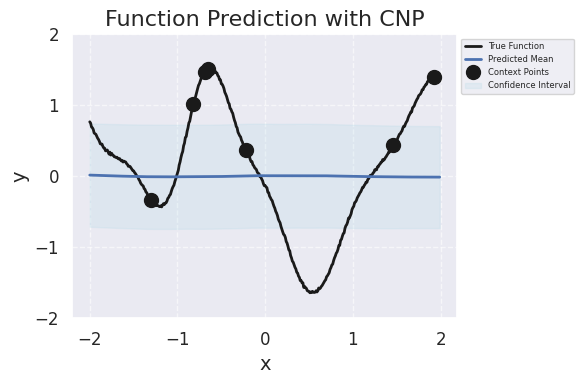

Training Progress:  10%|█         | 20000/200000 [19:52<3:01:27, 16.53it/s]

Iteration: 20000, Loss: 0.4858005940914154


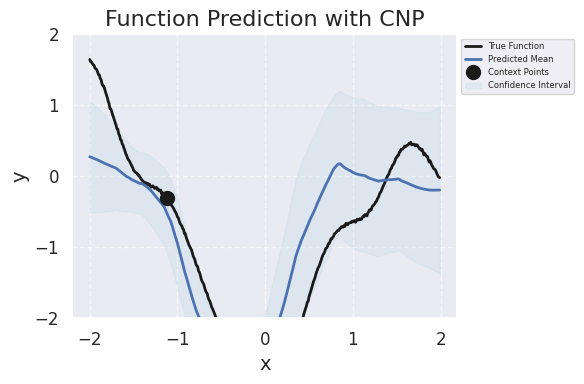

Training Progress:  20%|██        | 40000/200000 [39:51<2:39:35, 16.71it/s]

Iteration: 40000, Loss: 0.3533852696418762


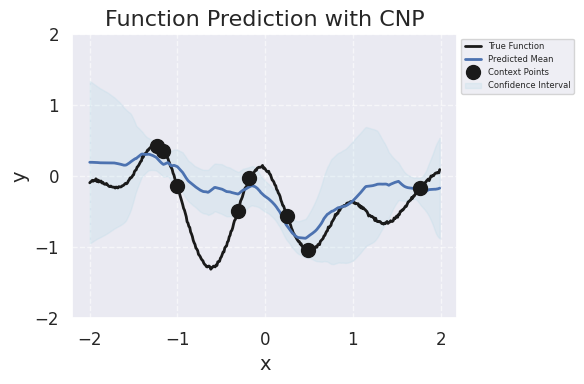

Training Progress:  30%|███       | 60000/200000 [59:51<2:17:21, 16.99it/s]

Iteration: 60000, Loss: 0.2089303582906723


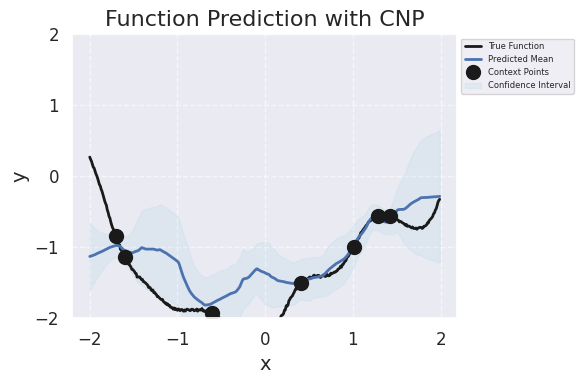

Training Progress:  40%|████      | 80000/200000 [1:21:16<2:10:34, 15.32it/s]

Iteration: 80000, Loss: 0.5377635359764099


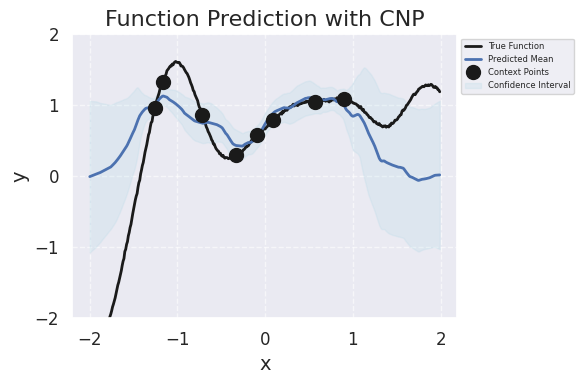

Training Progress:  50%|█████     | 100000/200000 [1:41:59<1:44:35, 15.94it/s]

Iteration: 100000, Loss: 0.1254950612783432


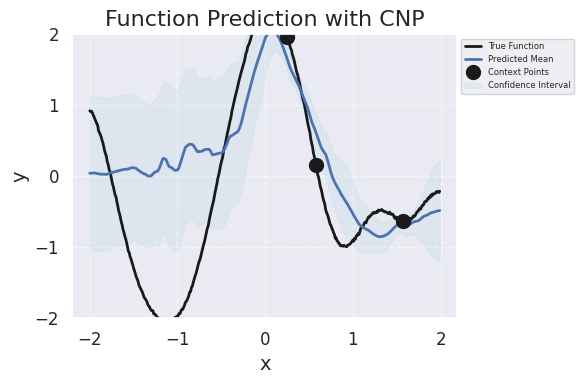

Training Progress:  60%|██████    | 120000/200000 [2:02:23<1:19:27, 16.78it/s]

Iteration: 120000, Loss: 0.17332588136196136


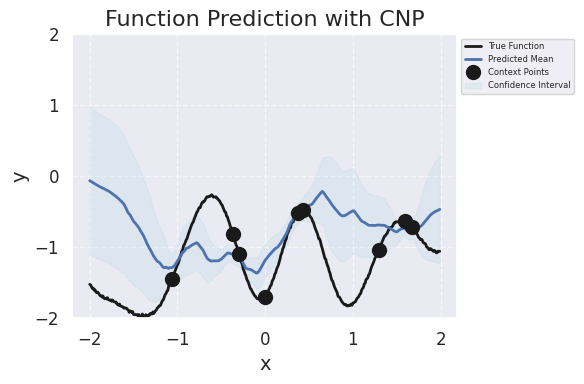

Training Progress:  70%|███████   | 140000/200000 [2:22:34<58:46, 17.02it/s]  

Iteration: 140000, Loss: -0.26401734352111816


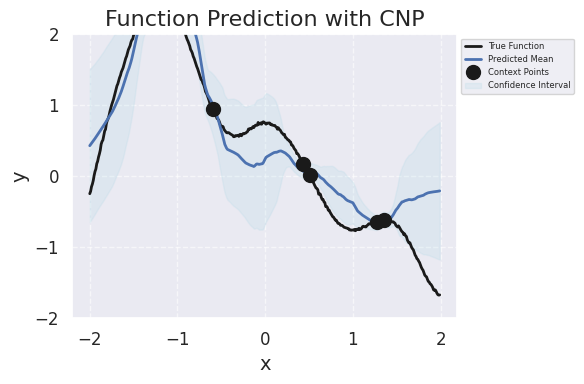

Training Progress:  80%|████████  | 160000/200000 [2:43:07<42:34, 15.66it/s]  

Iteration: 160000, Loss: -0.06862704455852509


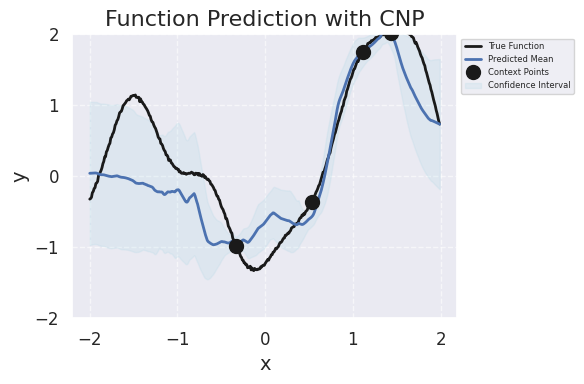

Training Progress:  90%|█████████ | 180000/200000 [3:03:54<21:38, 15.40it/s]  

Iteration: 180000, Loss: -0.018981626257300377


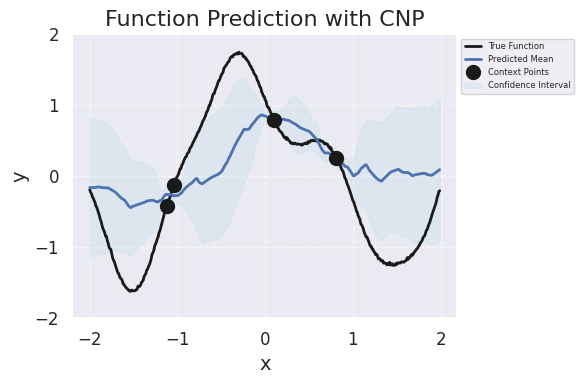

Training Progress: 100%|██████████| 200000/200000 [3:25:42<00:00, 16.20it/s]


In [13]:
from tqdm import tqdm

# Assuming `model` and `optimizer` are defined
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_directory = "/kaggle/working/checkpoints"
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_directory, max_to_keep=5)

# Restore from the latest checkpoint
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")
    
best_loss = float('inf')

for it in tqdm(range(TRAINING_ITERATIONS), desc='Training Progress'):
    for ((context_x, context_y, target_x), target_y) in train_dataset:
        loss = train_step(model, context_x, context_y, target_x, target_y)

    if it % PLOT_AFTER == 0:
        test_data_iter = iter(test_dataset.take(1))
        try:
            ((test_context_x, test_context_y, test_target_x), test_target_y) = next(test_data_iter)

            predicted_dist = model([test_context_x, test_context_y, test_target_x])
            mu, sigma = tf.split(predicted_dist, num_or_size_splits=2, axis=-1)
            
            if loss < best_loss:
                best_loss = loss
                # Construct the checkpoint name with iteration number and loss
                custom_checkpoint_name = f"ckpt_iter_{it}"
                custom_checkpoint_path = f"{checkpoint_directory}/{custom_checkpoint_name}"
                save_path = checkpoint.save(custom_checkpoint_path)

            print(f'Iteration: {it}, Loss: {loss.numpy()}')
            # Ensure your `plot_functions` is correctly defined to visualize results
            plot_functions(test_target_x.numpy(), test_target_y.numpy(), test_context_x.numpy(), test_context_y.numpy(), mu.numpy(), sigma.numpy())
        except StopIteration:
            print(f'Iteration: {it}, No more data to plot.')

In [16]:
model_save_path = './my_model'
model.save_weights(model_save_path)

In [ ]:
import os

checkpoint_directory = "/kaggle/working/checkpoints"

# Check if the directory exists
if os.path.exists(checkpoint_directory):
    # List all files and directories in the checkpoint directory
    files = os.listdir(checkpoint_directory)
    print("Contents of the checkpoint directory:")
    for file in files:
        print(file)
else:
    print(f"The directory {checkpoint_directory} does not exist.")

In [12]:
for item in os.listdir(checkpoint_directory ):
    item_path = os.path.join(checkpoint_directory, item)
    if os.path.isfile(item_path):
        size_bytes = os.path.getsize(item_path)
        print(f"File: {item}, Size: {size_bytes} bytes")

File: ckpt_iter_0-1.index, Size: 3159 bytes
File: ckpt_iter_20000-2.index, Size: 3159 bytes
File: ckpt_iter_20000-2.data-00000-of-00001, Size: 1205235 bytes
File: ckpt_iter_40000-3.data-00000-of-00001, Size: 1205235 bytes
File: ckpt_iter_100000-5.index, Size: 3159 bytes
File: ckpt_iter_40000-3.index, Size: 3159 bytes
File: ckpt_iter_60000-4.data-00000-of-00001, Size: 1205235 bytes
File: ckpt_iter_140000-6.index, Size: 3159 bytes
File: ckpt_iter_140000-6.data-00000-of-00001, Size: 1205235 bytes
File: ckpt_iter_60000-4.index, Size: 3159 bytes
File: ckpt_iter_0-1.data-00000-of-00001, Size: 1205235 bytes
File: checkpoint, Size: 93 bytes
File: ckpt_iter_100000-5.data-00000-of-00001, Size: 1205235 bytes


In [13]:
import os

checkpoint_directory = "/kaggle/working/"

# Check if the directory exists
if os.path.exists(checkpoint_directory):
    # List all files and directories in the checkpoint directory
    files = os.listdir(checkpoint_directory)
    print("Contents of the checkpoint directory:")
    for file in files:
        print(file)
else:
    print(f"The directory {checkpoint_directory} does not exist.")

Contents of the checkpoint directory:
checkpoints.zip
my_model.index
.virtual_documents
checkpoints
my_model.data-00000-of-00001
checkpoint


Model Testing

In [14]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

checkpoint_directory = "/kaggle/working/checkpoints"

# Load the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Checkpoint restored from:", latest_checkpoint)
else:
    print("No checkpoint found at:", checkpoint_directory)

Checkpoint restored from: /kaggle/working/checkpoints/ckpt_iter_140000-6


In [163]:
test_data_gen = FunctionRegressionDataGenerator(batch_size=1, max_num_context=51, testing=True)
test_data = tf.data.Dataset.from_generator(
    test_data_gen.generate_curves,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_x
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_y
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)   # target_x
        ),
        tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)       # target_y
    )
)  # No need to batch if evaluating one at a time, but you might want to add `.batch(1)` for consistency


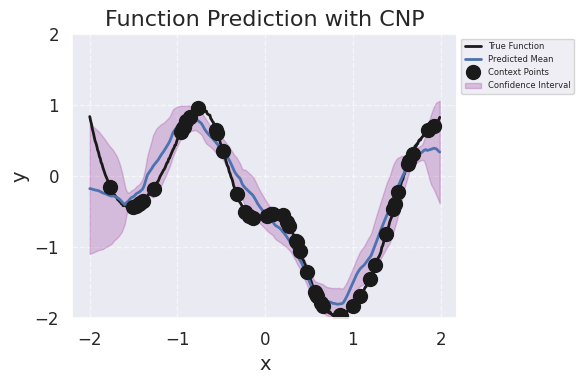

In [176]:
test_data_iter = iter(test_data.take(1))
((test_context_x, test_context_y, test_target_x), test_target_y) = next(test_data_iter)

predicted_dist = model([test_context_x, test_context_y, test_target_x])
mu, sigma = tf.split(predicted_dist, num_or_size_splits=2, axis=-1)
            
# Ensure your `plot_functions` is correctly defined to visualize results
plot_functions(test_target_x.numpy(), test_target_y.numpy(), test_context_x.numpy(), test_context_y.numpy(), mu.numpy(), sigma.numpy())

GP

In [177]:
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Define the kernel
amplitude = tf.constant(1.0, dtype=tf.float32)
length_scale = tf.constant(0.4, dtype=tf.float32)
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Define the Gaussian Process Regression Model
gp = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=test_target_x,
    observation_index_points=test_context_x,
    observations=test_context_y[..., 0],
    observation_noise_variance=1e-4
)

# GP predictions for plotting
mean_fn = gp.mean()
stddev_fn = gp.stddev()

In [160]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_gp_regression(test_context_x, test_context_y, test_target_x, test_target_y, mean_fn, stddev_fn):
    
    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

    """Plot Gaussian Process regression."""
    # Convert tensors to numpy arrays for plotting
    test_context_x = test_context_x.numpy()
    test_context_y = test_context_y.numpy()
    test_target_x = test_target_x.numpy()
    test_target_y = test_target_y.numpy()
    mean_fn = mean_fn.numpy()
    stddev_fn = stddev_fn.numpy()
    
    
    plt.plot(test_target_x.squeeze(), test_target_y.squeeze(), 'k-', linewidth=2, label='True Function')
    plt.plot(test_target_x.squeeze(), mean_fn.squeeze(), 'b', linewidth=2, label='Predicted Mean')
    plt.plot(test_context_x.squeeze(), test_context_y.squeeze(), 'ko', markersize=10, label='Context Points')
    plt.fill_between(test_target_x.squeeze(), 
                     (mean_fn - stddev_fn).squeeze(), 
                     (mean_fn + stddev_fn).squeeze(), 
                     color='purple', alpha=0.2, label='Confidence Interval')

    
    
    # Labels and title for better context
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('Function Prediction with GP', fontsize=16)

    # Adjust the y and x axis ticks for readability
    # Adjust the y and x axis ticks for the plot
    plt.yticks([-2, -1, 0, 1, 2], fontsize=12)
    plt.xticks([-2, -1, 0, 1, 2], fontsize=12)

    # Set the y-axis limits to match your data's scale better
    plt.ylim([-2, 2])

    # Enable the grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Modify the legend to improve readability
    # Add a legend outside of the plot to the right
    plt.legend(loc='upper left', fontsize=6, bbox_to_anchor=(1, 1))
    #plt.legend(loc='upper right', frameon=True, fontsize=12)


    # Show the plot with a tight layout to ensure no clipping
    plt.tight_layout()
    plt.savefig('./gpplot.png')
    plt.show()

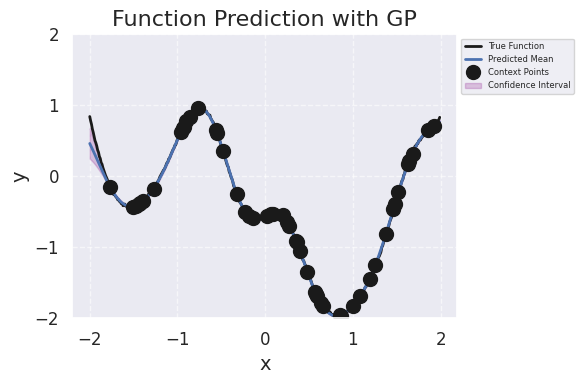

In [178]:
# Usage example:
plot_gp_regression(test_context_x, test_context_y, test_target_x, test_target_y, mean_fn, stddev_fn)